# Virtual staining from H&E with Eva

Virtual staining is an extension of image translation task, which is based on a fine-tuned weights.

In [ ]:
# change work dir
import os

os.chdir("/Your/path/to/Eva")

import matplotlib.pyplot as plt
import numpy as np
import torch
from omegaconf import OmegaConf

from Eva.utils import load_from_hf
from utils.overlay import compose_overlay

In [4]:
conf = OmegaConf.load("config.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"
patch_size = 8
image_size = 224

model = load_from_hf(
    repo_id="yandrewl/Eva",
    conf=conf,
    device=device,
    checkpoint_filename="Eva_ft.ckpt"  # fine-tuned weights 
)


Checkpoint downloaded to: /home/yfliu/.cache/huggingface/hub/models--yandrewl--Eva/snapshots/b48e234ef0d17ec6baba0f086188e6e87f3e319b/Eva_ft.ckpt
Model loaded successfully from HuggingFace Hub


In [5]:
mif_patch_np = np.load("examples/MIF_patch.npy")
he_patch_np = np.load("examples/HE_patch.npy") / 255.0
biomarkers = np.load("examples/biomarkers.npy", allow_pickle=True).tolist()

In [6]:
mif_placeholder = np.zeros_like(mif_patch_np) 
input_np = np.concatenate([mif_placeholder, 1 - he_patch_np], axis=-1)  # revered H&E in training
input_t = torch.from_numpy(input_np).unsqueeze(0).float().to(device)

marker_in = biomarkers + ['HECHA1', 'HECHA2', 'HECHA3']
marker_out = [biomarkers]

num_patches = (input_np.shape[0] // patch_size) * (input_np.shape[1] // patch_size)
infer_mask = torch.zeros(len(marker_in), num_patches, device=device)
infer_mask[:len(biomarkers), :] = 1.0

with torch.no_grad():
    image_recon, _, _ = model(
        input_t,
        marker_in=[marker_in],
        marker_out=marker_out,
        infer_mask=infer_mask,
        channel_mask=None,
    )

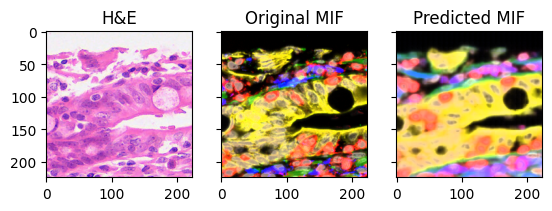

In [7]:
# visualization some selected channels
selected_biomarkers = ['DAPI', 'CD45', 'aSMA', 'CD31', 'Keratin8/18']
selected_idx = [biomarkers.index(m) for m in selected_biomarkers]

pred_vis = image_recon.detach().cpu().numpy()[0][..., selected_idx]
gt_vis = mif_patch_np[..., selected_idx]

selected_colors = ['gray', 'red', 'green', 'blue', 'yellow']

predicted_overlay = compose_overlay(
    pred_vis, colors=selected_colors, channels=list(range(len(selected_idx)))
)
original_overlay = compose_overlay(
    gt_vis, colors=selected_colors, channels=list(range(len(selected_idx)))
)

fig, ax = plt.subplots(1, 3, sharey=True)

ax[0].imshow(he_patch_np.astype(np.float32))
ax[1].imshow(original_overlay)
ax[2].imshow(predicted_overlay)

ax[0].set_title("H&E")
ax[1].set_title("Original MIF")
ax[2].set_title("Predicted MIF")

ax[1].sharey(ax[0])
ax[2].sharey(ax[0])
